<a href="https://colab.research.google.com/github/suleatmaca/Odev2/blob/master/Gender_Detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/drive/MyDrive/GENDER_DETECTION_DATASET"))

# Any results you write to the current directory are saved as output.

['img_align_celeba', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 'list_attr_celeba.csv', 'list_bbox_celeba.csv', 'list_landmarks_align_celeba.csv', 'list_eval_partition.csv', 'img_align_celeba.zip', 'img_align_celeba.zip (Unzipped Files)']


In [31]:
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [32]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

In [33]:
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
plt.style.use("ggplot")
%matplotlib inline

In [34]:
import tensorflow as tf
print(tf.__version__)

2.5.0


**1. Adım: Veri Keşfi**

178 x 218 piksel boyutlarındaki görüntüleri içeren CelebA Veri Kümesini kullanacağız. Aşağıda resimlerin nasıl göründüğüne dair bir örnek verilmiştir.

In [35]:
main_folder = "/content/drive/MyDrive/GENDER_DETECTION_DATASET/"
images_folder = main_folder + "img_align_celeba/img_align_celeba/"

example_pic = images_folder + "000506.jpg"

training_sample = 7000
validation_sample = 1000
test_sample = 1000
img_width = 178
img_height = 218
batch_size = 16
num_epochs = 5

Her resmin özelliklerini yükle

Dosya: *list_attr_celeba.csv*

In [36]:
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True)

In [37]:
df_attr.head(5)

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [38]:
df_attr.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.112250,0.264250,0.513100,0.204600,0.023200,0.151450,0.238600,0.2374,0.242650,0.148850,0.051750,0.20320,0.144050,0.057100,0.046350,0.064600,0.062500,0.041900,0.384900,0.450000,0.42155,0.479100,0.039350,0.115800,0.832100,0.27880,0.04315,0.276250,0.078000,0.063350,0.058400,0.479350,0.212350,0.316150,0.186300,0.049750,0.471050,0.122000,0.074050,0.779900
std,0.315682,0.440944,0.499841,0.403419,0.150542,0.358496,0.426238,0.4255,0.428696,0.355949,0.221527,0.40239,0.351149,0.232039,0.210247,0.245825,0.242068,0.200366,0.486584,0.497506,0.49382,0.499575,0.194431,0.319993,0.373787,0.44842,0.20320,0.447153,0.268178,0.243598,0.234504,0.499586,0.408981,0.464984,0.389358,0.217433,0.499174,0.327294,0.261859,0.414324
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.00000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
df_attr.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [40]:
df_attr.isnull().sum()

5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0
Young                  0


In [41]:
df_attr.shape

(20000, 40)

In [42]:
for i,j in enumerate(df_attr.columns):
    print(i+1, j)

1 5_o_Clock_Shadow
2 Arched_Eyebrows
3 Attractive
4 Bags_Under_Eyes
5 Bald
6 Bangs
7 Big_Lips
8 Big_Nose
9 Black_Hair
10 Blond_Hair
11 Blurry
12 Brown_Hair
13 Bushy_Eyebrows
14 Chubby
15 Double_Chin
16 Eyeglasses
17 Goatee
18 Gray_Hair
19 Heavy_Makeup
20 High_Cheekbones
21 Male
22 Mouth_Slightly_Open
23 Mustache
24 Narrow_Eyes
25 No_Beard
26 Oval_Face
27 Pale_Skin
28 Pointy_Nose
29 Receding_Hairline
30 Rosy_Cheeks
31 Sideburns
32 Smiling
33 Straight_Hair
34 Wavy_Hair
35 Wearing_Earrings
36 Wearing_Hat
37 Wearing_Lipstick
38 Wearing_Necklace
39 Wearing_Necktie
40 Young


Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

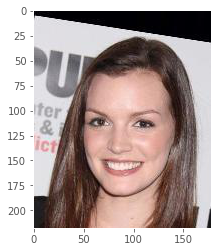

In [43]:
# load a example image

img = load_img(example_pic)
plt.grid(False)
plt.imshow(img)
df_attr.loc[example_pic.split('/')[-1]][['Smiling','Male',"Young"]]

**Özelliğin Dağılımı**

Daha önce belirtildiği gibi, bu bir görüntülerden cinsiyet tanıma projesidir. Veri setinde Erkek cinsiyetinden çok Kadın cinsiyeti bulunmaktadır. Bu, sonraki adımlarda verileri dengeleme ihtiyacı hakkında bize biraz fikir verir.

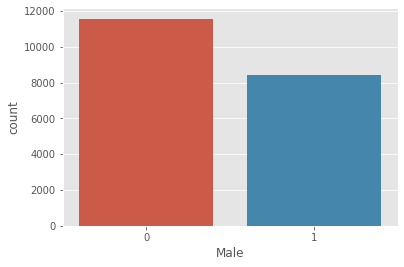

In [44]:
sns.countplot(df_attr["Male"])
plt.show()

**Özelliğin Dağılımı**

**Adım 2:** Veri Kümesini Eğitim, Doğrulama ve Test olarak ayırın

Görüntülerin eğitim, doğrulama ve veri setinin test edilmesi şeklinde önerilen bölümlemesi şu şekildedir:

1-20.000 eğitim alıyor 20.001-25.000 doğrulama yapıyor 25.001-30.000 test ediyor.

Bölüm, list_eval_partition.csv dosyasındadır

Zamanında yürütme, şimdiye kadar azaltılmış sayıda resim kullanacağız:

Eğitim *7000* görüntü, Doğrulama *1000* görüntü, Test *1000* görüntü.

In [45]:
df_partition = pd.read_csv(main_folder + "list_eval_partition.csv")
df_partition.head(5)

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [46]:
df_partition.sample(100)

,image_id,partition
5976,005977.jpg,0
2467,002468.jpg,0
16004,016005.jpg,2
1373,001374.jpg,0
7880,007881.jpg,0
...,...,...
14886,014887.jpg,1
10818,010819.jpg,1
10729,010730.jpg,1
2438,002439.jpg,0


0 =====> Eğitim

1 =====> Doğrulama

2 =====> Test Etme

In [47]:
df_partition["partition"].value_counts().sort_index()

0    10000
1     5000
2     5000
Name: partition, dtype: int64

Bölümü ve öznitelikleri aynı veri çerçevesinde birleştirin.

In [48]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr["Male"], how="inner")

df_par_attr.head(5)

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [49]:
df_par_attr.shape

(20000, 2)

**Bölümler Oluştur** (Eğitim, Doğrulama, Test)

Model için iyi bir performans elde etmek için görüntü sayısının dengelenmesi gerekir, her modelin kendi eğitim, doğrulama ve test dengeli verileri klasörü olacaktır.

Bu adımda, her bölümü oluşturmamıza yardımcı olacak işlevler oluşturacağız.

In [50]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,)+x.shape)
    return x

In [51]:
def generate_df(partition, attr, num_samples):
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
        
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (img_width, img_height)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

**Ön İşleme Görüntüleri: Veri Büyütme**

Görüntüler için Veri Büyütme üretir.

Veri Büyütme, orijinal olanlar üzerinde değişikliklerle görüntüler oluşturmaya izin verir. Model bu varyasyonlardan (değişen açı, boyut ve konum) öğrenecek ve konum, boyut ve konum bakımından aynı varyasyonlara sahip olabilecek daha önce hiç görülmemiş görüntüleri daha iyi tahmin edebilecektir.

Bir örnekle başlayalım: *Veri Büyütme*

Bu, veri artırma işleminden sonra bir görüntünün nasıl görüneceğidir (aşağıdaki verilen parametrelere göre).

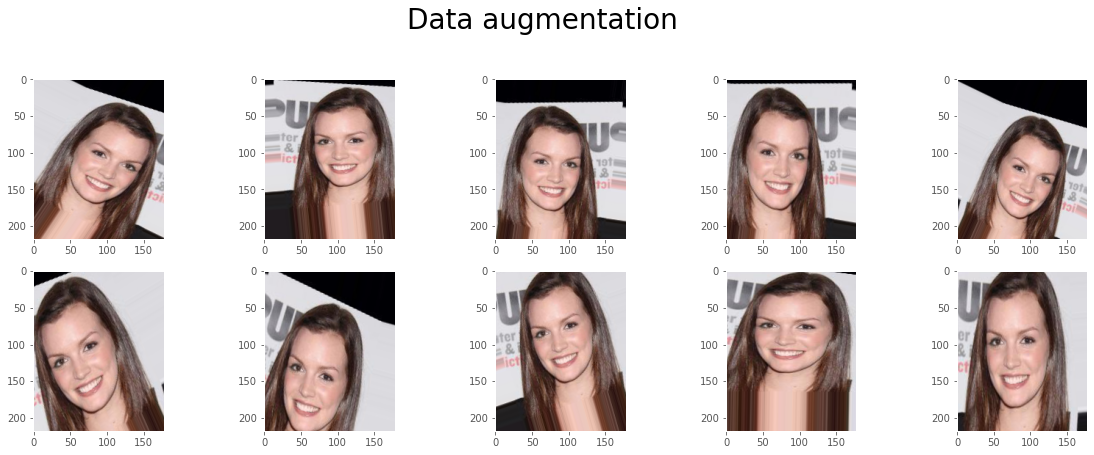

In [52]:
# generate image generator for data augmentation

datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# load one image and reshape

img = load_img(example_pic)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded image

plt.figure(figsize=(20,10))
plt.suptitle("Data augmentation", fontsize=28)

i = 0

for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3,5,i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(218,178, 3))
    
    if i==9:
        break
    i = i+1
    
plt.show()

Sonuç, öğrenme sürecinde bu tür görüntüleri almak ve hiç görülmemiş görüntüleri daha iyi tahmin etmek için modelin bu varyasyonlardan öğrenmesini sağlayan, orijinalinden modifikasyonlar içeren yeni bir görüntü setidir.

In [53]:
# build data generators

# train data

x_train, y_train = generate_df(0, "Male", training_sample)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

In [54]:
# validation data

x_valid, y_valid = generate_df(1, "Male", validation_sample)

Oluşturulan veri oluşturucu ve doğrulama için veriler ile modellemeye başlamaya hazırız.

Modeli Oluşturun - Cinsiyet Tanıma

**Modeli Ayarla**

In [56]:
# import inceptionv3 model

inc_model = InceptionV3(weights='/content/drive/MyDrive/GENDER_DETECTION_DATASET/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(img_height,img_width,3))

print("number of layers in the model : ", len(inc_model.layers))

number of layers in the model :  311


Üst katmanlar (sınıflandırma dahil) dahil değildir. Bu katmanlar, aşağıdaki katmanlar için değiştirilecektir:

**Özel Katmanlar Ekleme**

In [57]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [58]:
# creating the final model

model_ = Model(inputs=inc_model.input, outputs=predictions)

# lock initial layers to not to be trained

for layer in model_.layers[:52]:
    layer.trainable = False
    
# compile the model

model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# train the model

checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', verbose=1, save_best_only=True)

In [60]:
hist = model_.fit_generator(train_generator, validation_data=(x_valid, y_valid), steps_per_epoch=training_sample/batch_size, epochs=num_epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
437/437 [==============================] - 137s 171ms/step - loss: 0.7023 - accuracy: 0.5559 - val_loss: 0.7027 - val_accuracy: 0.5710

Epoch 00001: val_loss improved from inf to 0.70270, saving model to weights.best.inc.male.hdf5
Epoch 2/5
437/437 [==============================] - 66s 151ms/step - loss: 0.5610 - accuracy: 0.7091 - val_loss: 0.6742 - val_accuracy: 0.5930

Epoch 00002: val_loss improved from 0.70270 to 0.67424, saving model to weights.best.inc.male.hdf5
Epoch 3/5
437/437 [==============================] - 67s 153ms/step - loss: 0.4883 - accuracy: 0.7634 - val_loss: 0.6834 - val_accuracy: 0.5920

Epoch 00003: val_loss did not improve from 0.67424
Epoch 4/5
437/437 [==============================] - 65s 149ms/step - loss: 0.4387 - accuracy: 0.7946 - val_loss: 0.7324 - val_accuracy: 0.5680

Epoch 00004: val_loss did not improve from 0.67424
Epoch 5/5
437/437 [==============================] - 65s 149ms/step - loss: 0.3977 - accuracy: 0.8256 - val_loss: 0.8298 - 

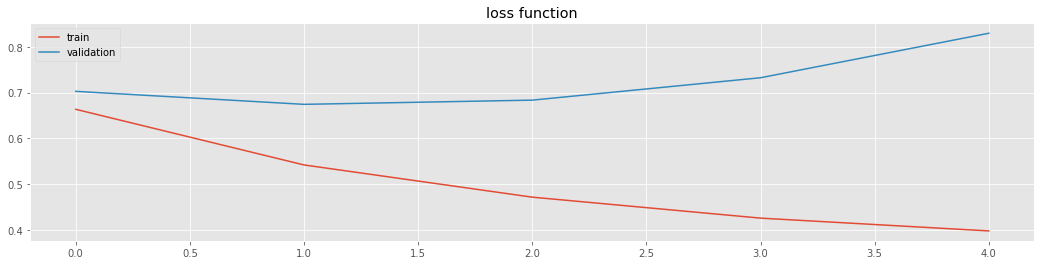

In [61]:
# plot loss with epochs

plt.figure(figsize=(18,4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.title('loss function')
plt.show()

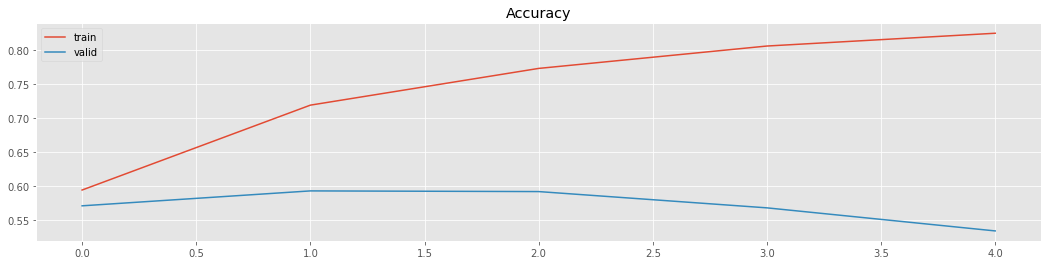

In [63]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

**Model değerlendirmesi**

In [64]:
# load the best model

model_.load_weights('weights.best.inc.male.hdf5')

In [65]:
# test data

x_test, y_test = generate_df(2, 'Male', test_sample)

# generate predictions

model_prediction = [np.argmax(model_.predict(feature)) for feature in x_test]

# report test accuracy

test_accuracy = 100 * (np.sum(np.array(model_prediction)==y_test)/len(model_prediction))
print('model evaluation')
print("test accuracy : ", test_accuracy)
print('f1 score : ', f1_score(y_test, model_prediction))

model evaluation
test accuracy :  56.2
f1 score :  0.5418410041841005
